In [ ]:
#check cuda version 
!nvcc --version 
# install pytorch according to the cuda version from the pytorch website
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
# install mmcv
!pip install mmcv-full==1.1.4
#clone github repository
!git clone https://github.com/rubeea/focal_phi_loss_mmsegmentation.git 
#install all requirements
!pip install -qr focal_phi_loss_mmsegmentation/requirements.txt 
%cd /content/focal_phi_loss_mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop

In [ ]:
!python tools/convert_datasets/chase_db1.py /content/drive/MyDrive/Colab_Dataset/CHASEDB1.zip

In [31]:
#declare global variables
root_dir= '/content/focal_phi_loss_mmsegmentation/data/'
data_root= "/content/focal_phi_loss_mmsegmentation/data/"
dataset= "CHASE_DB1"



#dataset= "mendeley"

In [32]:
import os

#script to extract data from zip files and create the directory structure for mendeley
#!python /content/focal_phi_loss_mmsegmentation/tools/convert_datasets/mendeley.py /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/train_gt.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_imgs.zip /content/focal_phi_loss_mmsegmentation/dataset_files/mendeley/val_gt.zip 

#check file counts
train_imgs= data_root + dataset+'/images/training'
val_imgs= data_root + dataset +'/images/validation'
train_gt= data_root + dataset+'/annotations/training'
val_gt= data_root + dataset+'/annotations/validation'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

20
8
40
16


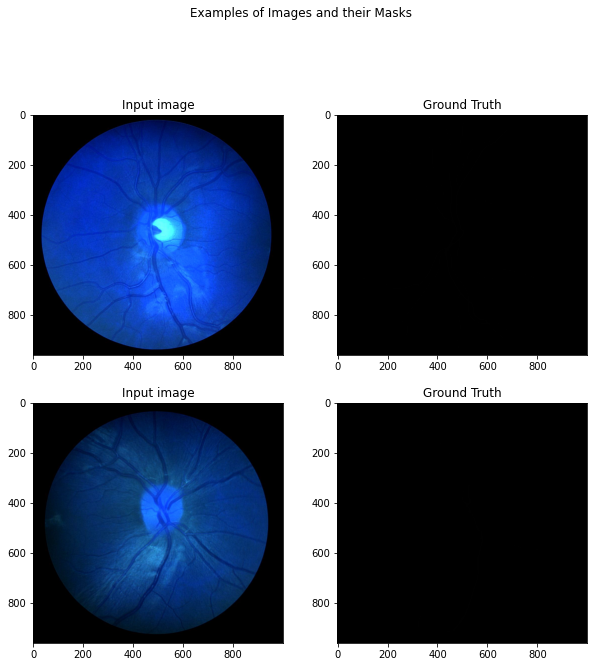

In [33]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+"/images/training"
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/annotations/training"

TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.png"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[120, 120, 120], [6, 230, 230]] #dataset palette

display_num = 3
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

In [43]:
#config for ACU-Net
from mmcv import Config
cfg = Config.fromfile('/content/focal_phi_loss_mmsegmentation/configs/unet/fcn_vanilla_unet_s5-d16_256x256_40k_hrf.py')

In [44]:
from mmseg.apis import set_random_seed
import torch

cfg_data_root = root_dir+dataset
train_img_dir = 'images/training'
train_ann_dir = 'annotations/training'
val_img_dir ='images/validation'
val_ann_dir ='annotations/validation'

data_root = 'CHASE_DB1'
img_dir = 'images'
ann_dir = 'annotations'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'ChaseDB1Dataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2


#Balanced CE loss
#assign class weights to tackle the imbalanced nature of the dataset in balanced CE loss
# weights = [0.02, 0.98]
# cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, 
#                                             loss_weight=1.0, class_weight= weights)

#Dice Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.5, beta=0.5, gamma=1.0, use_focal=False, loss_weight=1.0)

#Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=1.0, use_focal=False, loss_weight=1.0)

#Focal Tversky Loss
# cfg.model.decode_head.loss_decode=dict(type='TverskyLoss',  alpha=0.3, beta=0.7, gamma=0.75, use_focal=True, loss_weight=1.0)

#MCC loss
#cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=1.0)

#Focal Phi Loss
#cfg.model.decode_head.loss_decode=dict(type='PhiLoss', loss_weight=1.0, gamma=0.5)

#normalizing the dataset
cfg.img_norm_cfg = dict(
    mean= [142.393, 137.978, 83.073], std= [23.228, 20.046, 21.623], to_rgb=True) #for mendeley dataset

cfg.crop_size = (256, 256)

#dataset config
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 1.5)), #for mendeley dataset
    dict(type='RandomRotate', prob=0.5, degree=(45.0,315.0),pad_val=0,seg_pad_val=255), #for pldu and mendeley dataset
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale= (512, 512), #for mendeley dataset
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
#cfg.data.train.data_root = cfg.data_root
#cfg.data.train.img_dir = train_img_dir
#cfg.data.train.ann_dir = train_ann_dir

cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None
#############################################
cfg.data.val.type = cfg.dataset_type
#cfg.data.val.data_root = cfg.data_root
#cfg.data.val.img_dir = val_img_dir
#cfg.data.val.ann_dir = val_ann_dir

cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None
#############################################
cfg.data.test.type = cfg.dataset_type
#cfg.data.test.data_root = cfg.data_root
#cfg.data.test.img_dir = val_img_dir
#cfg.data.test.ann_dir = val_ann_dir

cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None

################
# Set up working dir to save files and logs.
cfg.work_dir = root_dir+'/work_dirs/tutorial'

cfg.total_iters = 160
cfg.runner.max_iters = 1000
cfg.log_config.interval = 50
cfg.evaluation.interval = 200 #validation at every 200 iterations
cfg.checkpoint_config.interval = 200

# Set seed to facilitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

#for Dice Loss, Tversky Loss and Focal Tversky Loss on Mendeley dataset use the following learning rates with Adam:
# lr = 5e-5

cfg.optimizer = dict(type='Adam', lr=1e-3, weight_decay=0.0001,
                     paramwise_cfg = dict(
                        custom_keys={
                            'head': dict(lr_mult=10.)
                        }
                        ))


# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type=

In [45]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmseg.utils import collect_env, get_root_logger
import mmcv
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]


meta = dict()
    # log env info
env_info_dict = collect_env()
env_info = '\n'.join([f'{k}: {v}' for k, v in env_info_dict.items()])
meta['env_info'] = env_info

meta['seed'] = cfg.seed
meta['exp_name'] = osp.basename(cfg.filename)
cfg.checkpoint_config.meta = dict(
            CLASSES=datasets[0].CLASSES,
            PALETTE=datasets[0].PALETTE)

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=meta)

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2022-07-26 08:06:17,169 - mmseg - INFO - Loaded 28 images
INFO:mmseg:Loaded 28 images
2022-07-26 08:06:18,312 - mmseg - INFO - Loaded 28 images
INFO:mmseg:Loaded 28 images
2022-07-26 08:06:18,319 - mmseg - INFO - Start running, host: root@a6163f54333b, work_dir: /content/focal_phi_loss_mmsegmentation/data/work_dirs/tutorial
INFO:mmseg:Start running, host: root@a6163f54333b, work_dir: /content/focal_phi_loss_mmsegmentation/data/work_dirs/tutorial
2022-07-26 08:06:18,323 - mmseg - INFO - workflow: [('train', 1)], max: 1000 iters
INFO:mmseg:workflow: [('train', 1)], max: 1000 iters
2022-07-26 08:06:26,706 - mmseg - INFO - Iter [50/1000]	lr: 9.602e-04, eta: 0:02:35, time: 0.164, data_time: 0.001, memory: 1663, decode.loss_seg: 0.3228, decode.acc_seg: 87.5093, loss: 0.3228
INFO:mmseg:Iter [50/1000]	

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 28/28, 4.7 task/s, elapsed: 6s, ETA:     0s

2022-07-26 08:08:08,188 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           94.21      97.02      99.83
vessel               19.43      32.54      19.87
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               56.82      64.78      59.85                32.54                97.02      94.29      19.87      99.83      10.25      89.75

INFO:mmseg:per class results:
Class                  IoU       Dice        Acc
background           94.21      97.02      99.83
vessel               19.43      32.54      19.87
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               56.82      64.78      59.85                32.54                97.02      94.29      19.87      99.83      10.25      89.75

2022-07-26 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 28/28, 4.5 task/s, elapsed: 6s, ETA:     0s

2022-07-26 08:09:57,923 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           96.04      97.98      99.29
vessel               49.87      66.55      54.62
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               72.96      82.27      76.95                66.55                97.98      96.19      54.62      99.29      14.84      85.16

INFO:mmseg:per class results:
Class                  IoU       Dice        Acc
background           96.04      97.98      99.29
vessel               49.87      66.55      54.62
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               72.96      82.27      76.95                66.55                97.98      96.19      54.62      99.29      14.84      85.16

2022-07-26 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 28/28, 4.5 task/s, elapsed: 6s, ETA:     0s

2022-07-26 08:11:46,635 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           95.95      97.93      99.35
vessel               48.17      65.02      52.36
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               72.06      81.48      75.86                65.02                97.93      96.09      52.36      99.35      14.26      85.74

INFO:mmseg:per class results:
Class                  IoU       Dice        Acc
background           95.95      97.93      99.35
vessel               48.17      65.02      52.36
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               72.06      81.48      75.86                65.02                97.93      96.09      52.36      99.35      14.26      85.74

2022-07-26 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 28/28, 4.4 task/s, elapsed: 6s, ETA:     0s

2022-07-26 08:13:35,473 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           96.38      98.16      99.13
vessel               55.23      71.16      61.68
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               75.80      84.66      80.40                71.16                98.16      96.53      61.68      99.13      15.92      84.08

INFO:mmseg:per class results:
Class                  IoU       Dice        Acc
background           96.38      98.16      99.13
vessel               55.23      71.16      61.68
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               75.80      84.66      80.40                71.16                98.16      96.53      61.68      99.13      15.92      84.08

2022-07-26 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 28/28, 4.4 task/s, elapsed: 6s, ETA:     0s

2022-07-26 08:15:25,498 - mmseg - INFO - per class results:
Class                  IoU       Dice        Acc
background           96.78      98.36      99.12
vessel               60.38      75.29      67.52
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               78.58      86.83      83.32                75.29                98.36      96.93      67.52      99.12      14.91      85.09

INFO:mmseg:per class results:
Class                  IoU       Dice        Acc
background           96.78      98.36      99.12
vessel               60.38      75.29      67.52
Summary:
Scope                 mIoU      mDice       mAcc       Powerline Dice      Background Dice       aAcc        TPR        TNR        FDR  Precision
global               78.58      86.83      83.32                75.29                98.36      96.93      67.52      99.12      14.91      85.09

2022-07-26 0

8


/content/focal_phi_loss_mmsegmentation/mmseg/models/segmentors/base.py:277: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


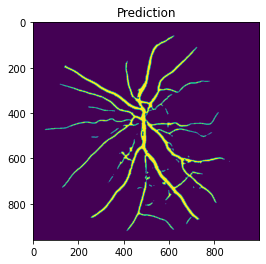

<Figure size 576x432 with 0 Axes>

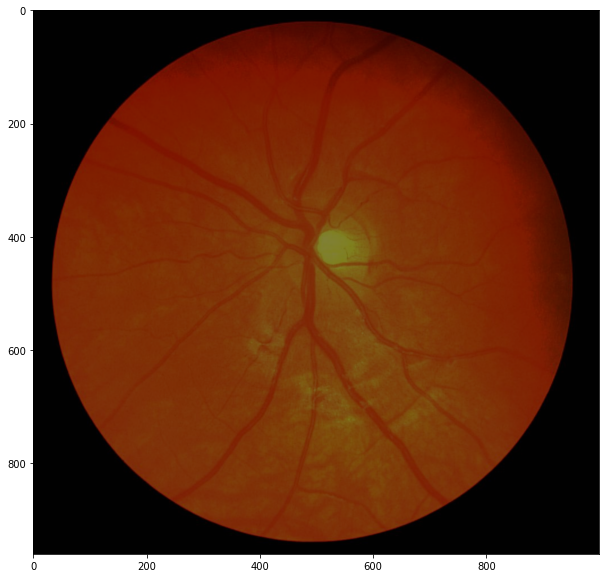

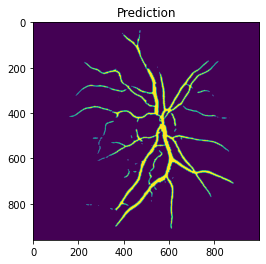

<Figure size 576x432 with 0 Axes>

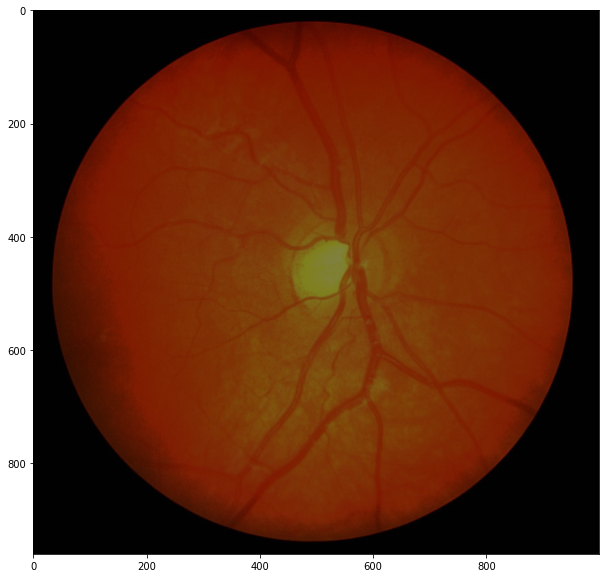

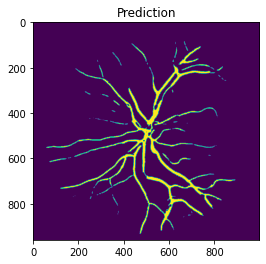

<Figure size 576x432 with 0 Axes>

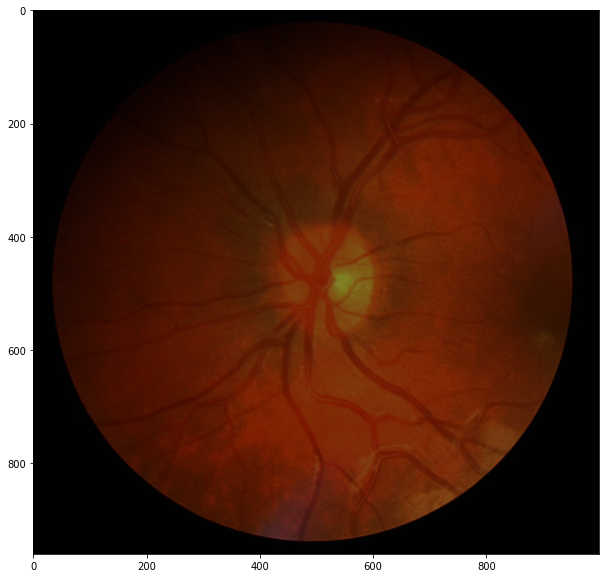

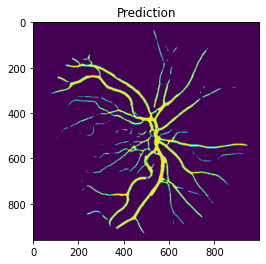

<Figure size 576x432 with 0 Axes>

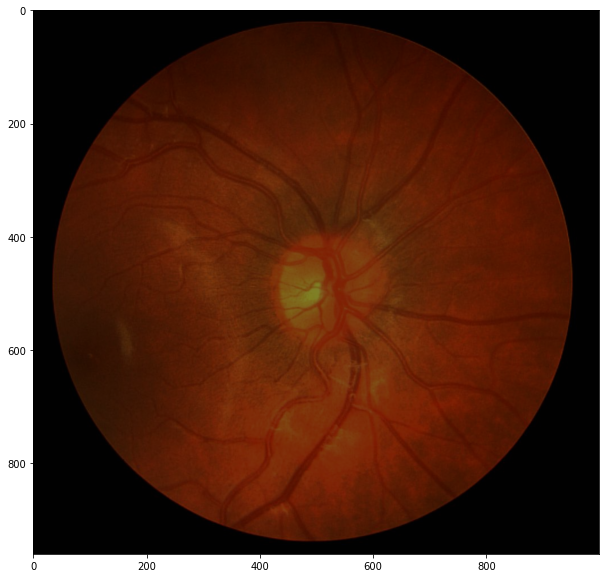

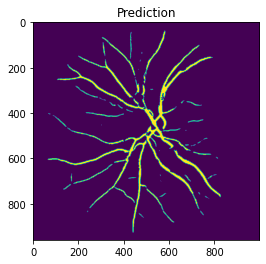

<Figure size 576x432 with 0 Axes>

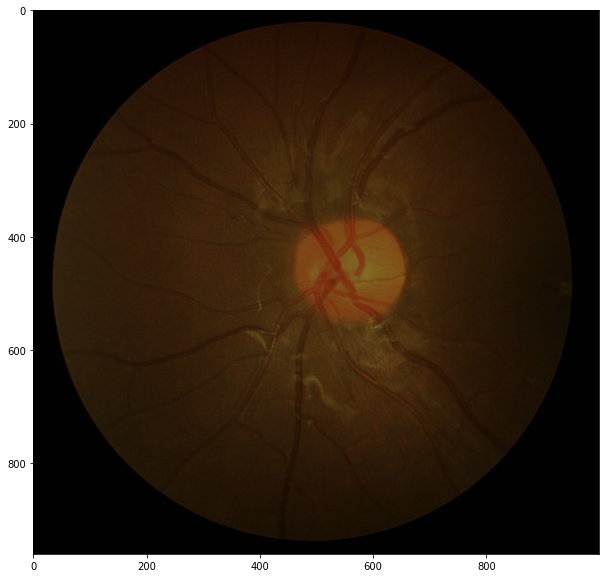

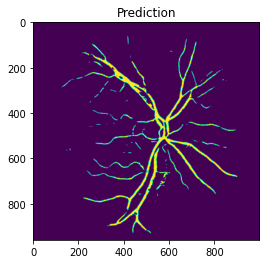

<Figure size 576x432 with 0 Axes>

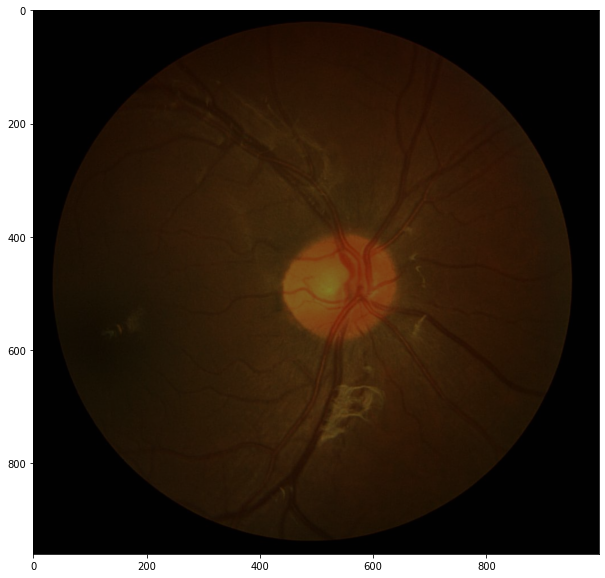

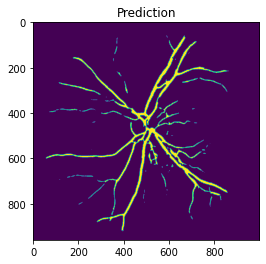

<Figure size 576x432 with 0 Axes>

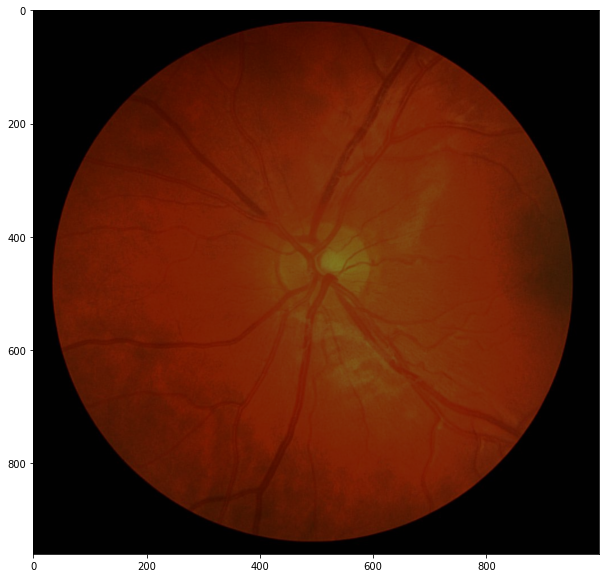

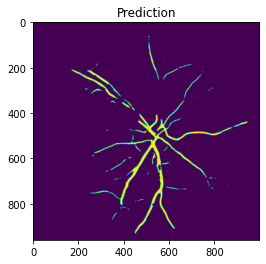

<Figure size 576x432 with 0 Axes>

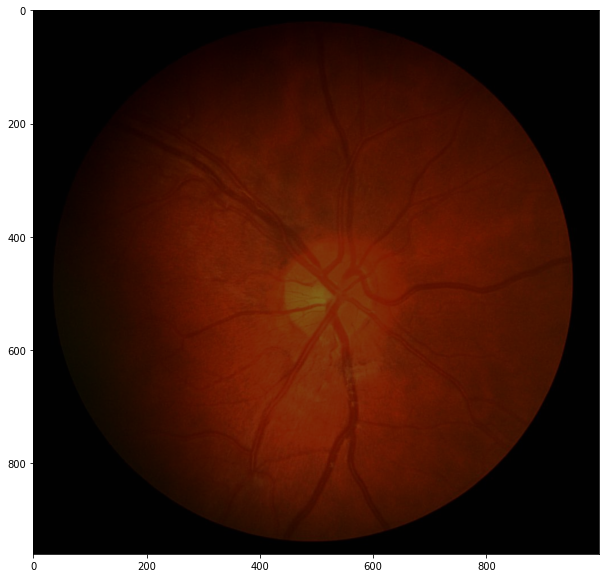

In [55]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

PATH_TO_TEST_IMAGES_DIR="/content/focal_phi_loss_mmsegmentation/data/CHASE_DB1/images/validation"
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.png"))

TEST_IMAGE_PATHS.sort()


checkpoint= root_dir+'/work_dirs/tutorial/iter_800.pth' #checkpoint path
model = init_segmentor(cfg, checkpoint, device='cuda:0')
palette = [[2, 2, 2], [1, 1, 1]] #dataset palette
print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  
  result = inference_segmentor(model, img)
  
  # img_name= TEST_IMAGE_PATHS[i].split("/")[7] #for overlay

  #prediction mask
  arr= np.array(result)
  arr=np.squeeze(arr)

  #overlay image
  # overlay = model.show_result(img, result, palette=palette, show=False)

  # plt.subplot(1, 7 , 1)
  # plt.imshow(img)
  # plt.title("Input image")

  # plt.subplot(1, 7,  3)
  # plt.imshow(label)
  # plt.title("Ground Truth")

  # plt.subplot(1, 7,  5)
  plt.imshow(arr)
  plt.title("Prediction")

  # plt.subplot(1, 7,  7)
  # plt.imshow(mmcv.bgr2rgb(overlay))
  # plt.title("Overlay")

  # show_result_pyplot(model, img, result,palette)

  

  plt.figure(figsize=(8, 6))
  show_result_pyplot(model, img, result,palette)